In [1]:
import math
import os
import random
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from scipy.ndimage import distance_transform_edt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import f1_score, jaccard_score, mean_squared_error
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define the U-Net model architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.conv_last(dec1)

In [3]:
model = UNet().to(device)

cannot find the pretrained mobilenetv2 backbone


FileNotFoundError: [Errno 2] No such file or directory: './pretrained/mobilenetv2_human_seg.ckpt'

In [34]:
class RandomHorizontalFlip(transforms.RandomHorizontalFlip):
    def __call__(self, img, mask):
        if random.random() < self.p:
            return F.hflip(img), F.hflip(mask)
        return img, mask


class RandomVerticalFlip(transforms.RandomVerticalFlip):
    def __call__(self, img, mask):
        if random.random() < self.p:
            return F.vflip(img), F.vflip(mask)
        return img, mask


class RandomRotation(transforms.RandomRotation):
    def __call__(self, img, mask):
        angle = self.get_params(self.degrees)
        return F.rotate(img, angle), F.rotate(mask, angle)


class RandomResizedCrop(transforms.RandomResizedCrop):
    def __call__(self, img, mask):
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        return F.resized_crop(
            img, i, j, h, w, self.size, self.interpolation
        ), F.resized_crop(mask, i, j, h, w, self.size, self.interpolation)


class ColorJitter(transforms.ColorJitter):
    def __call__(self, img, mask):
        return super().__call__(img), mask

In [35]:
class CustomDataset(Dataset):
    def __init__(self, base_dir, subset, transform=None):
        self.image_dir = os.path.join(base_dir, subset, "images")
        self.mask_dir = os.path.join(base_dir, subset, "masks")
        self.transform = transform
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        base_filename = os.path.splitext(self.images[idx])[0]

        # Find the corresponding mask file
        mask_path = None
        for ext in [".png", ".jpg", ".jpeg"]:
            potential_mask_path = os.path.join(self.mask_dir, base_filename + ext)
            if os.path.exists(potential_mask_path):
                mask_path = potential_mask_path
                break

        if mask_path is None:
            raise FileNotFoundError(f"Mask file not found for image: {img_path}")

        try:
            image = Image.open(img_path).convert("RGB")
        except UnidentifiedImageError:
            print(f"UnidentifiedImageError: Cannot identify image file {img_path}")
            return None  # Skip this file

        try:
            mask = Image.open(mask_path).convert("L")
        except UnidentifiedImageError:
            print(f"UnidentifiedImageError: Cannot identify mask file {mask_path}")
            return None  # Skip this file

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Ensure mask is a single-channel tensor (1, height, width)
        mask = mask.squeeze(0)

        return image, mask

In [36]:
# # Combine the transforms
# data_transforms = transforms.Compose(
#     [
#         RandomResizedCrop(size=(320, 320), scale=(0.8, 1.0)),
#         RandomHorizontalFlip(),
#         RandomVerticalFlip(),
#         RandomRotation(degrees=15),
#         ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#         transforms.ToTensor(),
#     ]
# )

In [37]:
base_dir = r"C:\Users\lewka\Downloads\processed_h5_folder"
subset = "train"
transform = transforms.Compose([transforms.Resize((320, 320)), transforms.ToTensor()])

dataset = CustomDataset(base_dir, subset, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [38]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [39]:
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))  # Add channel dimension to masks
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

Epochs:   0%|                                                                                   | 0/10 [00:01<?, ?it/s]


ValueError: not enough values to unpack (expected 4, got 1)

In [19]:
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": num_epochs,
}
checkpoint_path = "simple_matting_checkpoint.pth"

In [ ]:
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved to {checkpoint_path}")

IoU: 0.0100
Dice Coefficient: 0.0198
SAD: 203909.0000
MAD: 1.9913
MSE: 0.9842
Gradient Error: 0.0065
Connectivity Error: 206.2425


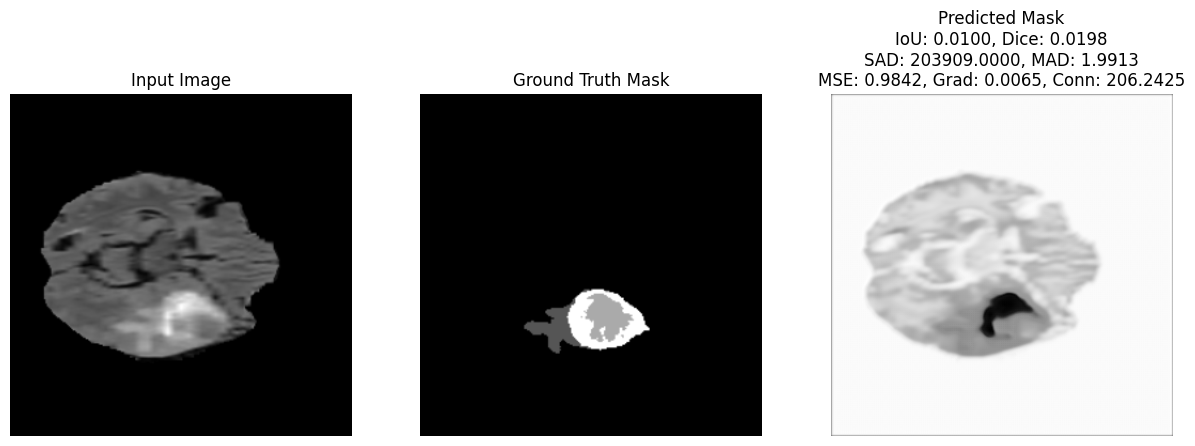

In [25]:
def calculate_sad(predicted_mask, ground_truth_mask):
    return np.sum(np.abs(predicted_mask - ground_truth_mask))


def calculate_mad(predicted_mask, ground_truth_mask):
    return np.mean(np.abs(predicted_mask - ground_truth_mask))


def calculate_grad_error(predicted_mask, ground_truth_mask):
    grad_pred = np.gradient(predicted_mask)
    grad_gt = np.gradient(ground_truth_mask)
    return np.mean(
        np.abs(grad_pred[0] - grad_gt[0]) + np.abs(grad_pred[1] - grad_gt[1])
    )


def calculate_conn_error(predicted_mask, ground_truth_mask):
    def connectivity(mask):
        return distance_transform_edt(mask) - distance_transform_edt(1 - mask)

    conn_pred = connectivity(predicted_mask)
    conn_gt = connectivity(ground_truth_mask)
    return np.mean(np.abs(conn_pred - conn_gt))


def display_results(model, dataset, device, index=0):
    # Evaluate the Model
    test_image, test_mask = dataset[index]
    test_image, test_mask = test_image.to(device), test_mask.to(device)
    with torch.no_grad():
        predicted_mask = model(test_image.unsqueeze(0)).squeeze().cpu().numpy()

    # Binarize the predicted mask
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)
    test_mask_binary = test_mask.cpu().numpy().astype(np.uint8)

    # Calculate IoU
    iou = jaccard_score(test_mask_binary.flatten(), predicted_mask_binary.flatten())

    # Calculate Dice Coefficient
    dice = f1_score(test_mask_binary.flatten(), predicted_mask_binary.flatten())

    # Calculate SAD
    sad = calculate_sad(predicted_mask_binary, test_mask_binary)

    # Calculate MAD
    mad = calculate_mad(predicted_mask_binary, test_mask_binary)

    # Calculate MSE
    mse = mean_squared_error(
        test_mask_binary.flatten(), predicted_mask_binary.flatten()
    )

    # Calculate Gradient Error
    grad_error = calculate_grad_error(predicted_mask_binary, test_mask_binary)

    # Calculate Connectivity Error
    conn_error = calculate_conn_error(predicted_mask_binary, test_mask_binary)

    # Print metrics
    print(f"IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"SAD: {sad:.4f}")
    print(f"MAD: {mad:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"Gradient Error: {grad_error:.4f}")
    print(f"Connectivity Error: {conn_error:.4f}")

    # Display the result
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(test_image.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(test_mask.cpu().numpy(), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(
        f"Predicted Mask\nIoU: {iou:.4f}, Dice: {dice:.4f}\nSAD: {sad:.4f}, MAD: {mad:.4f}\nMSE: {mse:.4f}, Grad: {grad_error:.4f}, Conn: {conn_error:.4f}"
    )
    plt.imshow(predicted_mask, cmap="gray")
    plt.axis("off")

    plt.show()


# Load the model checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

# Display results for the first image in the dataset
display_results(model, dataset, device, index=0)

In [ ]:
# Load the Model and Optimizer State to Continue Training
checkpoint = torch.load(checkpoint_path)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"]

model.to(device)
model.train()

# Continue Training
num_epochs = 10  # Number of additional epochs
for epoch in range(start_epoch, start_epoch + num_epochs):
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))  # Add channel dimension to masks
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(
        f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Loss: {running_loss/len(dataloader):.4f}"
    )

# Save the Model and Optimizer State Again
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": start_epoch + num_epochs,
}
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved to {checkpoint_path}")